In [1]:
# %matplotlib inline
import torch
import torch.nn.functional as F
from models.definitions.transformerocr import OCR
from models.definitions.vocab import Vocab
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from PIL import Image
from utils.predictor import process_input, translate
from typing import List

In [2]:
vocab = '''aAàÀảẢãÃáÁạẠăĂằẰẳẲẵẴắẮặẶâÂầẦẩẨẫẪấẤậẬbBcCdDđĐeEèÈẻẺẽẼéÉẹẸêÊềỀểỂễỄếẾệỆfFgGhHiIìÌỉỈĩĨíÍịỊjJkKlLmMnNoOòÒỏỎõÕóÓọỌôÔồỒổỔỗỖốỐộỘơƠờỜởỞỡỠớỚợỢpPqQrRsStTuUùÙủỦũŨúÚụỤưƯừỪửỬữỮứỨựỰvVwWxXyYỳỲỷỶỹỸýÝỵỴzZ0123456789!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ '''
vocab = Vocab(vocab)

config = {
    'device': 'cpu',
    'dataset': {
        'image_height': 64,
        'image_min_width': 32,
        'image_max_width': 2048
    },
    'predictor': {
        'beamsearch': False
    },
    'cnn': {
        'pretrained': False,
        'ss':
             [[2, 2],
             [2, 2],
             [2, 1],
             [2, 1],
             [1, 1]],
        'ks':
             [[2, 2],
             [2, 2],
             [2, 1],
             [2, 1],
             [1, 1]],
        'hidden': 256
    },
    'transformer': {  
        'd_model': 256,
        'nhead': 8,
        'num_encoder_layers': 6,
        'num_decoder_layers': 6,
        'dim_feedforward': 2048,
        'max_seq_length': 1024,
        'pos_dropout': 0.1,
        'trans_dropout': 0.1
    }
}
device = 'cpu'

model = OCR(len(vocab), 'vgg19_bn', config['cnn'], config['transformer'])

In [3]:
weight = 'models/weights/transformer/cin_vtp_215.pth'
model.load_state_dict(torch.load(weight, map_location=torch.device('cpu')))
model.eval();

In [4]:
raw_image = Image.open('test/images/others/trucly1.jpg')

In [5]:
 image = process_input(raw_image, 
                       config['dataset']['image_height'], 
                       config['dataset']['image_min_width'], 
                       config['dataset']['image_max_width']).to(device)

s, prob = translate(image, model)            
s = s[0].tolist()
prob = prob[0]

# return vocab.decode(s), prob

In [6]:
vocab.decode(s)

'Trúc Ly'

# Visualize

In [7]:
feature_w, feature_h, image_w, image_h = 0, 0, 0, 0
weight_dict = {
    'self_attn': [],
    'multihead_attn': [],
}

def hook_cnn(module, inputs, outputs):
    global feature_h
    global feature_w
    global image_w
    global image_h
    image_h, image_w = inputs[0].shape[-2:]
    feature_h, feature_w = outputs[0].shape[-2:]

def hook_self_attn(module, inputs, outputs):
    global weight_dict
    weight_dict['self_attn'].append(outputs[-1])

def hook_multihead_attn(module, inputs, outputs):
    global weight_dict
    weight_dict['multihead_attn'].append(outputs[-1])

In [8]:
model.cnn.model.features.register_forward_hook(hook_cnn)
model.transformer.transformer.decoder.layers[-1].self_attn.register_forward_hook(hook_self_attn)
model.transformer.transformer.decoder.layers[-1].multihead_attn.register_forward_hook(hook_multihead_attn)

s, prob = translate(image, model)
s = s[0].tolist()
prob = prob[0]
output = vocab.decode(s)

In [9]:
print(len(weight_dict['self_attn']))
print(len(weight_dict['multihead_attn']))

8
8


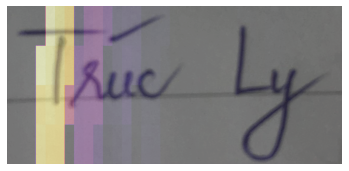

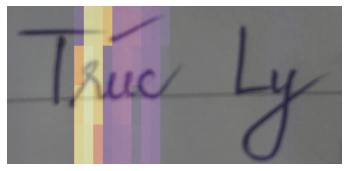

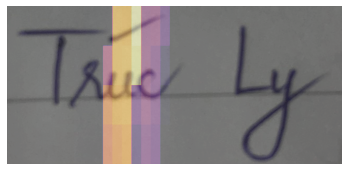

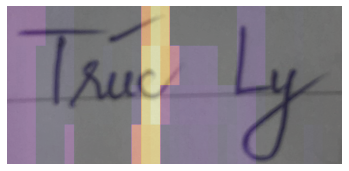

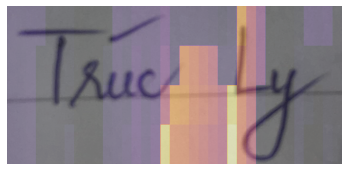

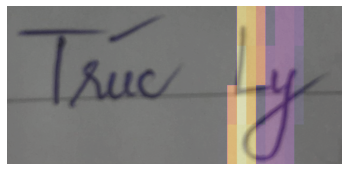

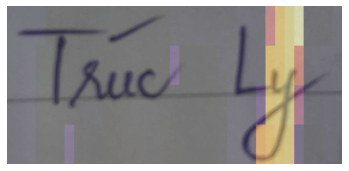

In [10]:
def visualize_attention_weight(weights: List[torch.Tensor]):
    # weight: (N, L, S = W * H)
    N = 1
    W = feature_w
    H = feature_h
    S = W * H
    
    for step in range(0, len(output)):    
        alpha = 0.6
        weight_step_0 = weights[step]
        # -----------------
        np_image = np.array(raw_image)
        plt.imshow(np_image, alpha=alpha)
        
        plt.imshow(np_image, alpha=alpha)
        plt.axis('off')

        weight = weight_step_0[0][step]    # [S=W * H]
        feature_image = weight.reshape(W, H).transpose(-2, -1) # [H, W]
        feature_image = F.interpolate(feature_image.unsqueeze(0).unsqueeze(0), np_image.shape[:2]).squeeze(0).squeeze(0)
        np_feature_image = feature_image.numpy()
        
#         im = Image.fromarray(np_feature_image)
#         im.save(f'img_{step}.png')
        
        plt.imshow(np_feature_image, alpha=1-alpha, cmap='inferno')    
    
        plt.savefig(f'attn{step}.png')
        plt.show()

#     fig, ax = plt.subplots(len(output), 1, figsize=(20, 40))

#     for step in range(0, len(output)):
    
#         alpha = 0.6
#         weight_step_0 = weights[step]
#         # -----------------
#         np_image = np.array(raw_image)
#         plt.imshow(np_image, alpha=alpha)
        
#         ax[step].imshow(np_image, alpha=alpha)
#         ax[step].axis('off')

#         weight = weight_step_0[0][step]    # [S=W * H]
#         feature_image = weight.reshape(W, H).transpose(-2, -1) # [H, W]
#         feature_image = F.interpolate(feature_image.unsqueeze(0).unsqueeze(0), np_image.shape[:2]).squeeze(0).squeeze(0)
#         np_feature_image = feature_image.numpy()
        
# #         im = Image.fromarray(np_feature_image)
# #         im.save(f'img_{step}.png')
        
#         ax[step].imshow(np_feature_image, alpha=1-alpha, cmap='inferno')    
#         ax[step].set_title(output[step])
    
#     plt.savefig('attn.jpg')
#     plt.show()

visualize_attention_weight(weight_dict['multihead_attn'])

Trúc Ly


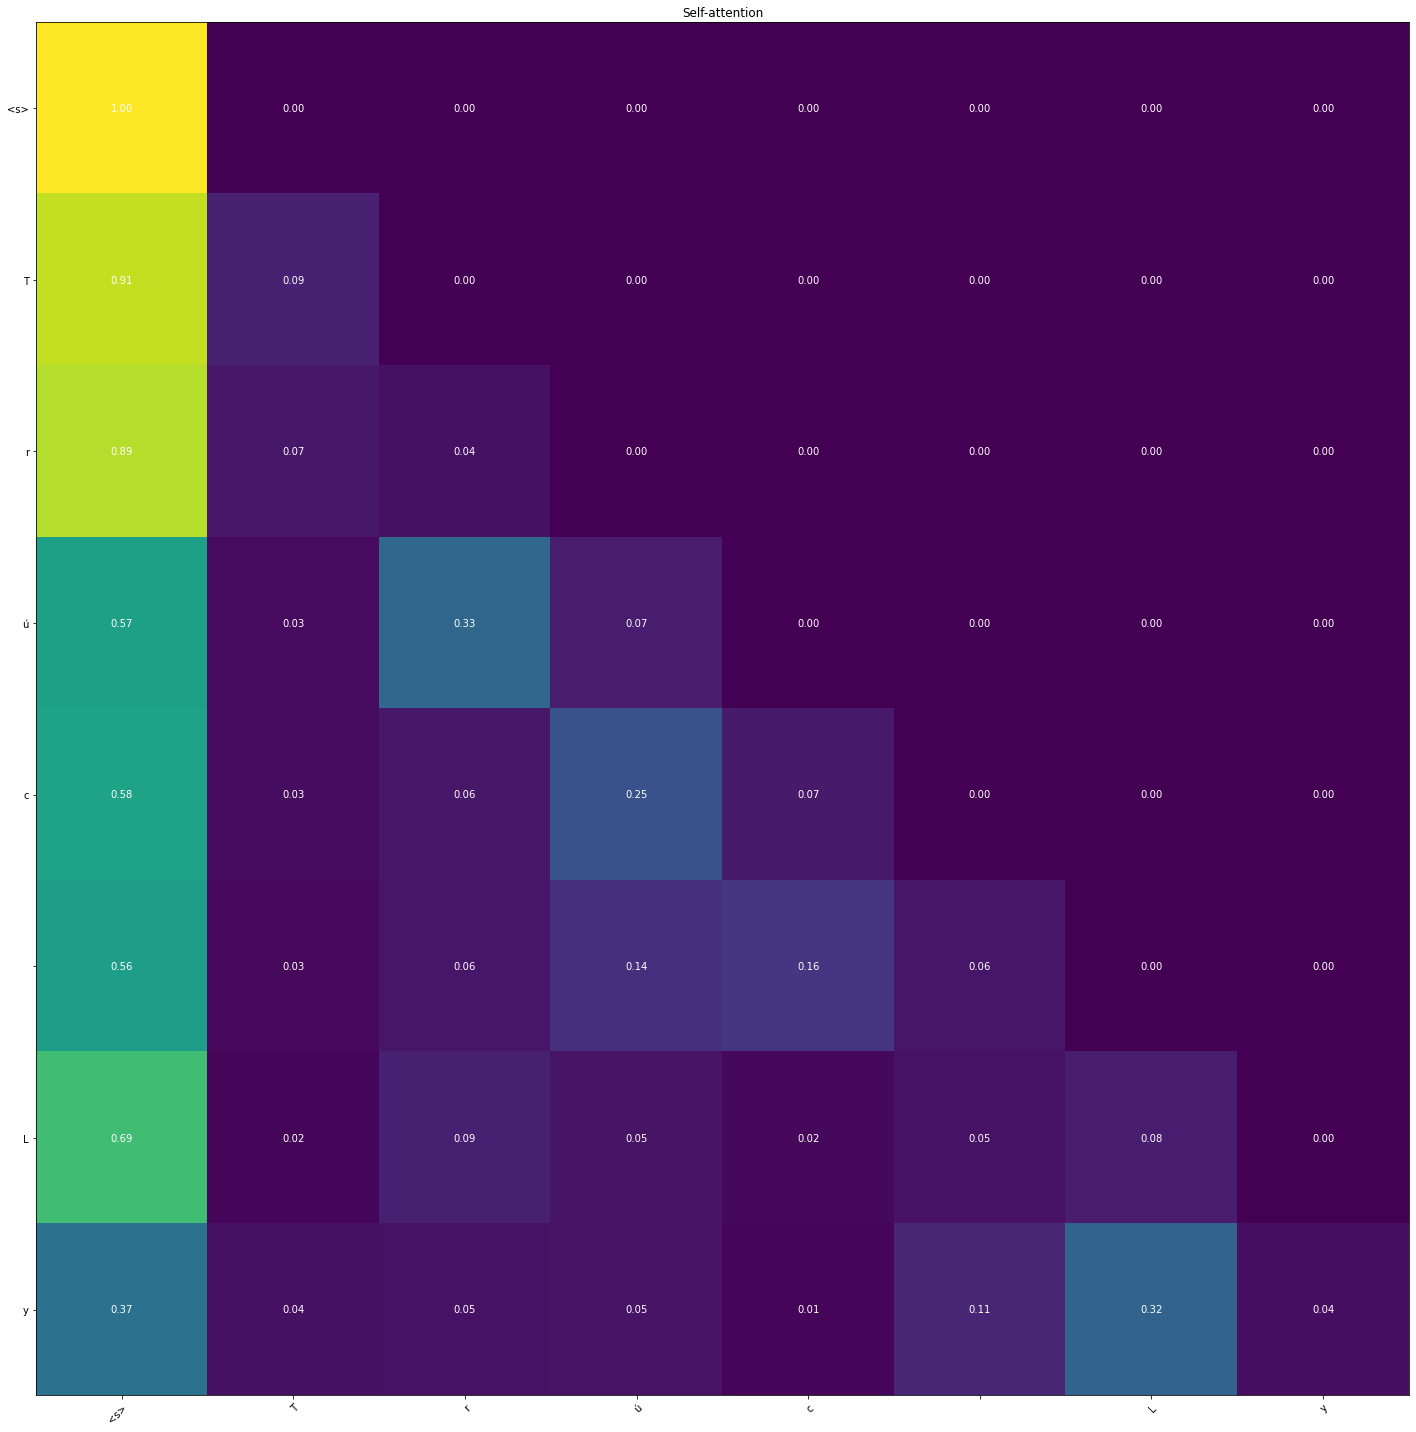

In [11]:
print(output)
output = [c for c in output]
output = ['<s>'] + output
def visualize_self_attention_weight(weights: List[torch.Tensor]):
    # weights: List of [N, L, L]
    data = weights[-1][0].numpy()  # [L, L]

    fig, ax = plt.subplots(figsize=(20, 20))
    im = ax.imshow(data)
#     output = list(map(model.vocab.int2char, outputs[i]))
#     output = model.vocab.process_label_invert(output)


    # We want to show all ticks...
    ax.set_xticks(np.arange(len(output)))
    ax.set_yticks(np.arange(len(output)))
    # # ... and label them with the respective list entries
    sns.heatmap(sample, annot=True, fmt=".2f", annot_kws={"fontsize": 25}, ax=axes[i, 0])
    axes[i, 0].set_ylabel('Time steps', fontdict={'fontsize': 25})
    axes[i, 0].set_xticklabels(output, fontdict={'fontsize': 20})
    axes[i, 0].set_yticklabels(output, fontdict={'fontsize': 20, 'verticalalignment': 'center',

    # # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
            rotation_mode="anchor")

    # # Loop over data dimensions and create text annotations.
    for i in range(len(output)):
        for j in range(len(output)):
            text = ax.text(j, i, f'{data[i, j].item():.2f}', ha="center", va="center", color="w")

    ax.set_title("Self-attention")
    fig.tight_layout()
    plt.show()

visualize_self_attention_weight(weight_dict['self_attn'])

In [12]:
def visualize_dec_weights(weights, layer_idx=-1):
    print(weights.shape) # [L,B,T,T]
    L, B, T, T = weights.shape
    fig, axes = plt.subplots(B, 1, figsize=(10, 8), sharex=True, sharey=True, squeeze=False)

    weights = weights[layer_idx] # [B, T, T]

    for i, sample in enumerate(weights):
        # sample: [T, T]
        output = list(map(model.vocab.int2char, outputs[i]))
        output = model.vocab.process_label_invert(output)
#         output = [model.vocab.SOS] + output[:-1]
        output = ['<s>'] + output[:-1]
        print(output)
        sns.heatmap(sample, annot=True, fmt=".2f", annot_kws={"fontsize": 25}, ax=axes[i, 0])
        axes[i, 0].set_ylabel('Time steps', fontdict={'fontsize': 25})
        axes[i, 0].set_xticklabels(output, fontdict={'fontsize': 20})
        axes[i, 0].set_yticklabels(output, fontdict={'fontsize': 20, 'verticalalignment': 'center',
 'horizontalalignment': 'right'}, rotation='horizontal')

    plt.tight_layout()
    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()
    fig.savefig(f"misc/attn-dec_{layer_idx}.png")
visualize_dec_weights(weight_dict['self_attn']) # visualize first sample only

AttributeError: 'list' object has no attribute 'shape'